# `ANFISpy` tutorial

Here, we are going to give a brief tutorial about the `ANFISpy` module usage.

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from ANFISpy import ANFIS

## Regression

Loading the dataset:

In [2]:
SEED = 10
torch.manual_seed = SEED

url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"

df = pd.read_csv(url)
df = df.dropna()

FEATURES = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
TARGET = ['body_mass_g']

x = df[FEATURES].values
y = df[TARGET].values

Train, test and validation split:

In [3]:
x, index = np.unique(x, axis=0, return_index=True)
y = y[index]

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=SEED)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=SEED)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

x_train_max = x_train.max(dim=0, keepdim=True)[0]
y_train_max = y_train.max(dim=0, keepdim=True)[0]
x_test_max = x_test.max(dim=0, keepdim=True)[0]
y_test_max = y_test.max(dim=0, keepdim=True)[0]
x_val_max = x_val.max(dim=0, keepdim=True)[0]
y_val_max = y_val.max(dim=0, keepdim=True)[0]

x_train /= x_train_max
y_train /= y_train_max
x_test /= x_test_max
y_test /= y_test_max
x_val /= x_val_max
y_val /= y_val_max

Creating the DataLoaders:

In [4]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

The model is instantiated with a dictionary, containing information about the `inputs` and `output`. The `inputs` key has the following keys:
- `n_sets`: list with number of fuzzy set of each input variable;
- `uod`: list with tuples/lists representing the universe of discourse of each input variable;
- `var_names`: list with strings for the name of each input variable;
- `mf_names`: list with strings for the name of the fuzzy sets associated to each input variable.

The `output` has similar keys:
- `var_names`: list with strings for the name of the output variable;
- `n_classes`: if the model is a regressor, set the value to 1.  

This dictionary is then passed to instatiate the model, which is going to use the information in it for plots and model visualization.

In [5]:
n_vars = 3
mf_names = [['L', 'M', 'H']]

variables = {
    'inputs': {
        'n_sets': [3, 3, 3],
        'uod': n_vars * [(0, 1)],
        'var_names': FEATURES,
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': TARGET[0],
        'n_classes': 1,
    },
}

anfis = ANFIS(variables, 'gaussian', mean_rule_activation=True)

Defining the loss function and optimizer:

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(anfis.parameters(), lr=0.001)

Training the model:

In [7]:
epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    anfis.train()
    train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = anfis(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    anfis.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = anfis(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 9:
        print(f'Epoch {epoch+1}/{epochs}: train_loss: {train_loss:.4f} validation_loss {val_loss:.4f}')

Epoch 10/100: train_loss: 0.7587 validation_loss 0.5807
Epoch 20/100: train_loss: 0.0629 validation_loss 0.1189
Epoch 30/100: train_loss: 0.0278 validation_loss 0.0647
Epoch 40/100: train_loss: 0.0186 validation_loss 0.0461
Epoch 50/100: train_loss: 0.0160 validation_loss 0.0359
Epoch 60/100: train_loss: 0.0141 validation_loss 0.0292
Epoch 70/100: train_loss: 0.0129 validation_loss 0.0253
Epoch 80/100: train_loss: 0.0109 validation_loss 0.0228
Epoch 90/100: train_loss: 0.0113 validation_loss 0.0213
Epoch 100/100: train_loss: 0.0096 validation_loss 0.0202


Plotting the loss and validation curve:

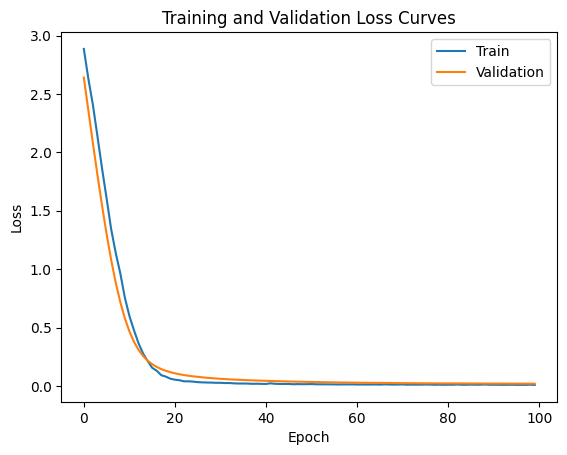

In [8]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

Calculating the RMSE of the model

In [9]:
anfis.eval()  
test_loss = 0.0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = anfis(x_batch)
        y_pred *= y_test_max
        y_batch *= y_test_max
        mse = torch.mean((y_pred - y_batch) ** 2)
        test_loss += mse.item()

rmse = torch.sqrt(torch.tensor(test_loss / len(test_loader)))

print(f"RMSE: {rmse.item():.4f}")

RMSE: 866.6793


Plotting the membership functions of the model:

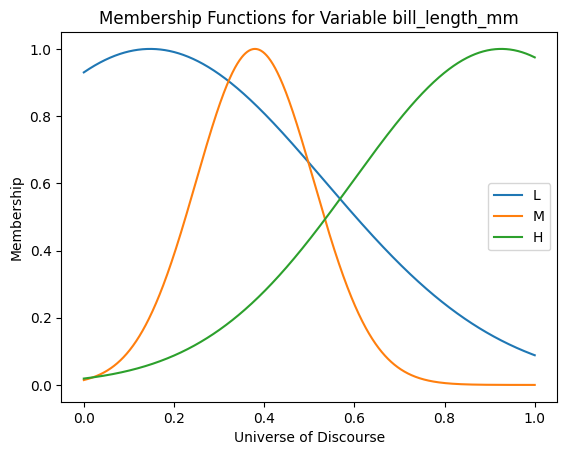

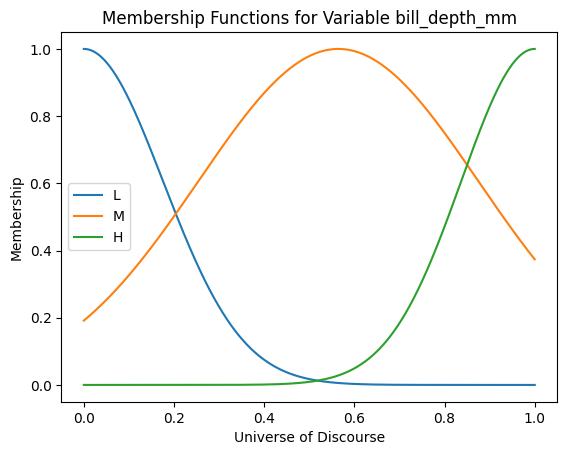

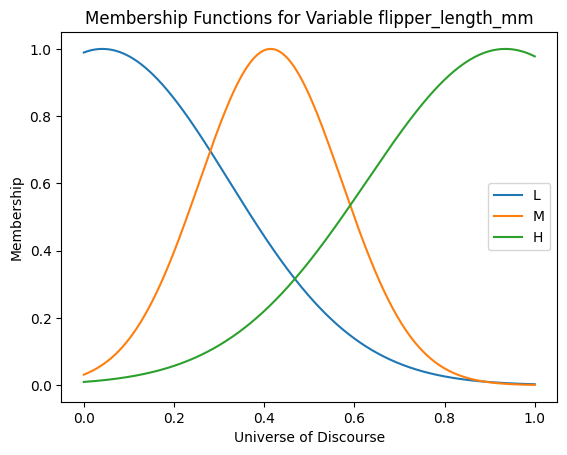

(None, None, None)

In [10]:
anfis.plot_var(FEATURES[0]), anfis.plot_var(FEATURES[1]), anfis.plot_var(FEATURES[2])

The following plot depicts the projection of the fuzzy rules into two variables, with the fuzzy sets on the side of the plot.

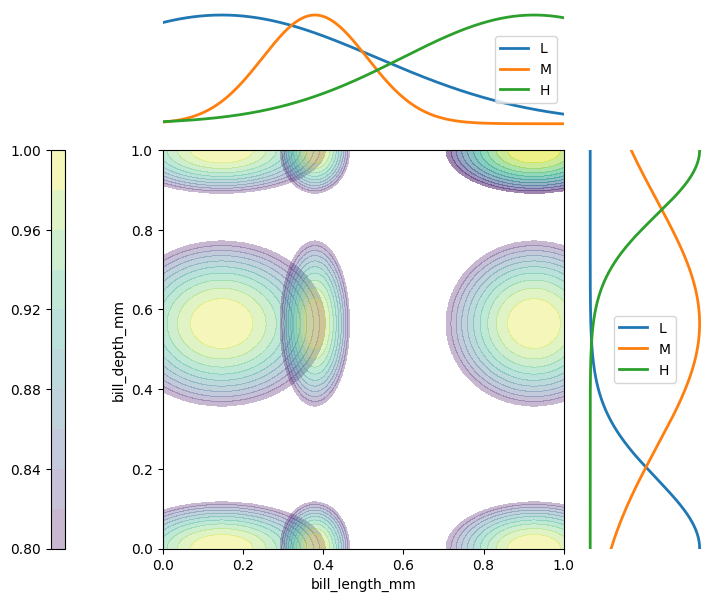

In [11]:
anfis.plot_rules(FEATURES[:2], thr=0.8)

Printing the rules:

In [12]:
rules, mean_activation = anfis.print_rules(mean_rule_activation=True)

rules

['IF bill_length_mm IS L AND bill_depth_mm IS L AND flipper_length_mm IS L, THEN body_mass_g IS f0',
 'IF bill_length_mm IS L AND bill_depth_mm IS L AND flipper_length_mm IS M, THEN body_mass_g IS f1',
 'IF bill_length_mm IS L AND bill_depth_mm IS L AND flipper_length_mm IS H, THEN body_mass_g IS f2',
 'IF bill_length_mm IS L AND bill_depth_mm IS M AND flipper_length_mm IS L, THEN body_mass_g IS f3',
 'IF bill_length_mm IS L AND bill_depth_mm IS M AND flipper_length_mm IS M, THEN body_mass_g IS f4',
 'IF bill_length_mm IS L AND bill_depth_mm IS M AND flipper_length_mm IS H, THEN body_mass_g IS f5',
 'IF bill_length_mm IS L AND bill_depth_mm IS H AND flipper_length_mm IS L, THEN body_mass_g IS f6',
 'IF bill_length_mm IS L AND bill_depth_mm IS H AND flipper_length_mm IS M, THEN body_mass_g IS f7',
 'IF bill_length_mm IS L AND bill_depth_mm IS H AND flipper_length_mm IS H, THEN body_mass_g IS f8',
 'IF bill_length_mm IS M AND bill_depth_mm IS L AND flipper_length_mm IS L, THEN body_mass_

Visualizing the mean activation of the rules:

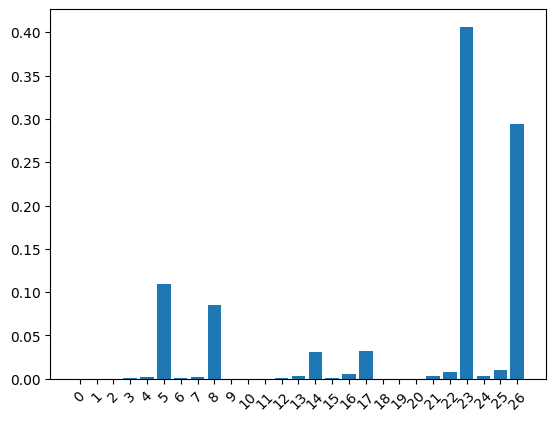

In [13]:
names = [f'{i}' for i in range(27)]

fig, ax = plt.subplots()

ax.bar(names, mean_activation)

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45)

plt.show()

## Classification

Now, we are going to perform a classification problem.

In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Loading the dataset:

In [15]:
SEED = 10
torch.manual_seed = SEED

url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"

df = pd.read_csv(url)
df = df.dropna()

FEATURES = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
TARGET = ['species']

x = df[FEATURES].values
y = df[TARGET].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())

Train, test and validation split:

In [16]:
x, index = np.unique(x, axis=0, return_index=True)
y = y[index]

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=SEED)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=SEED)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

x_train_max = x_train.max(dim=0, keepdim=True)[0]
x_test_max = x_test.max(dim=0, keepdim=True)[0]
x_val_max = x_val.max(dim=0, keepdim=True)[0]

x_train /= x_train_max
x_test /= x_test_max
x_val /= x_val_max

Creating the DataLoaders:

In [17]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Instantiating the model:

In [18]:
n_vars = 4
mf_names = [['L', 'M', 'H']]

variables = {
    'inputs': {
        'n_sets': n_vars * [3],
        'uod': n_vars * [(0, 1)],
        'var_names': FEATURES,
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': TARGET[0],
        'n_classes': len(label_encoder.classes_),
    },
}

anfis = ANFIS(variables, 'gaussian', mean_rule_activation=True)

Defining the loss and the optimizer:

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(anfis.parameters(), lr=0.001)

Training the model:

In [20]:
epochs = 100
train_losses, val_losses = [], []

for epoch in range(epochs):
    anfis.train()
    train_loss = 0.0
    
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = anfis(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    anfis.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = anfis(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 10 == 9:
        print(f'Epoch {epoch+1}/{epochs}: train_loss: {train_loss:.4f} validation_loss {val_loss:.4f}')

Epoch 10/100: train_loss: 0.7872 validation_loss 0.8584
Epoch 20/100: train_loss: 0.3685 validation_loss 0.5764
Epoch 30/100: train_loss: 0.2109 validation_loss 0.6125
Epoch 40/100: train_loss: 0.1597 validation_loss 0.8260
Epoch 50/100: train_loss: 0.1396 validation_loss 0.8312
Epoch 60/100: train_loss: 0.1316 validation_loss 0.8484
Epoch 70/100: train_loss: 0.1463 validation_loss 0.8033
Epoch 80/100: train_loss: 0.1225 validation_loss 0.8878
Epoch 90/100: train_loss: 0.1182 validation_loss 0.8965
Epoch 100/100: train_loss: 0.1120 validation_loss 0.7806


Evaluating the performance:

In [21]:
with torch.no_grad():
    y_pred = anfis(x_test)
    y_pred = torch.argmax(y_pred, dim=1)  
    accuracy = accuracy_score(y_test.numpy(), y_pred.numpy())  
    print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9104


Plotting the confusion matrix:

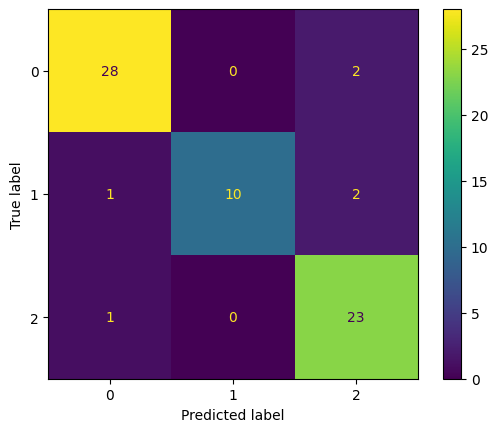

In [22]:
true_labels = y_test.numpy()
predicted_labels = y_pred.numpy()

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.show()